In [20]:
"""
Alexandre
2024/10/17
"""

'\nAlexandre\n2024/10/17\n'

# **Nest::simulator**

In [21]:
import os

cwd = os.getcwd()
print(cwd)

results_fodler_name = "A_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## Initialisation

In [22]:
import nest

In [23]:
# set general parameters
seed = 1
dt = 0.1
num_threads = 16

# initialize nest kernel
nest.ResetKernel() # reset to clear all element already here (connections, nodes, time...)
nest.SetKernelStatus({ # 
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})


Oct 24 18:39:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## First encoding test

### _input generation_ (stimulus_representation.ipynb)

In [24]:
# import librairies input stimulus generator
from utils.inputs import generate_piecewise_constant_signal
import numpy as np

In [25]:
# stimulus parameters
step_duration = 20.    # [ms]
scale = 1.         # input scaling factor [Hz]
num_steps = 1_000        # number of unique input values

In [26]:
# generation of the stimulus
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
    seed=seed, 
    num_steps=num_steps,
    step_duration=step_duration, 
    resolution=dt, 
    scale=scale
    )
sig = sig / 2

np.save(os.path.join(results_fodler_name, "sig"), sig)
np.save(os.path.join(results_fodler_name, "times"), times)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

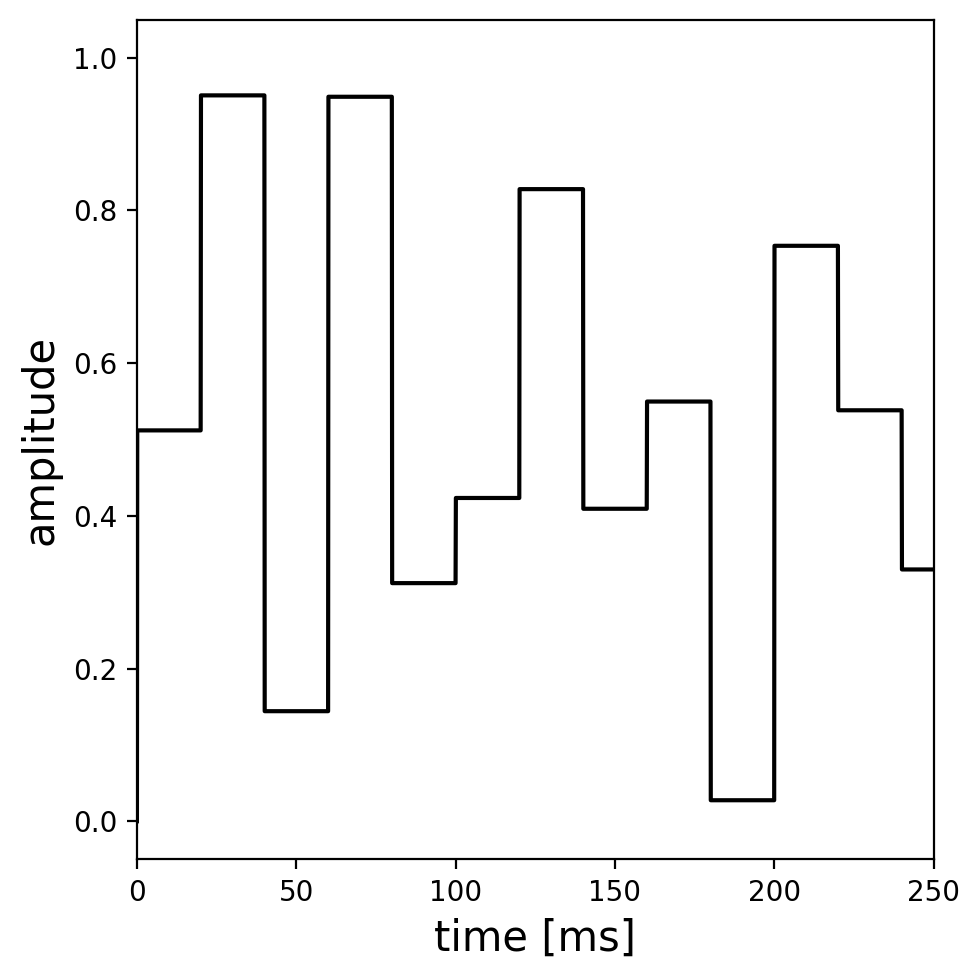

In [29]:
# graphical representation
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.plot(
    times,
    sig,
    color="black"
)

ax.set_xlabel(r'time [ms]', size=15)
ax.set_ylabel(r'amplitude', size=15)

ax.set_xlim(0, 250)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "input_pattern.pdf"), dpi=150)
plt.show()

### _create the encoding network_ (fading_memory_encoded.ipynb)
All of this is based on a simple population of spiking neurons based on this equation : 
$$
I_{in}(t) = <x(t)^{T}e> + \beta 
$$
In wich :
* $e$ is the tuning named `tuning`
* $\beta$ is a fiwed bias named `J_bias`

This is just a replication of the encoding layer see in the notebook "fading_memory_encoded.ipynb".

In [10]:
# parameters of the encoding layer
nEnc = 500  # number of neurons in the encoding layer
gamma = 0.25  # scaled factor for 

J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000. # 
thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
thresholds = np.maximum(thresholds, -65.) # 
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

In [11]:
# create the encoding layer
enc_layer = nest.Create(
    model='iaf_psc_delta', 
    n=nEnc, 
    params={'I_e': J_bias}
)
print(enc_layer)

NodeCollection(metadata=None, model=iaf_psc_delta, size=500, first=1, last=500)


In [12]:
step_generator = nest.Create(
	model='step_current_generator', 
	n=nEnc
)
amplitudes = np.zeros((nEnc, len(inp_amplitudes)))

for n in range(nEnc): # for each neuron in the encoding layer
	
	# transform the input as function of the tuning of each neuron
	amplitudes[n, :] = inp_amplitudes * tuning[n]
	
	# change parameters of each neuron in the input layer
	enc_layer[n].set(
		{
			'V_m': Vm0[n], # set the membrane potential initialisation
			'V_th': thresholds[n] # set the excitation threshold
		}
	)

	# change caracteristics of the input generator
	step_generator[n].set(
		{
			'amplitude_times': inp_times, # set the time
			'amplitude_values': amplitudes[n] # set the amplitude
		}
	)

	# connect the input generator to the encoding layer neuron one-by-one
	nest.Connect(
		step_generator[n],
		enc_layer[n]
	)

In [13]:
# record the activity of the encoding layer
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)

### _create the main network with default parameters_

In [14]:
# main network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 200                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [15]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [16]:
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

### _connect the two main part of the encoding decoding network_

In [17]:
# connect the encoding layer to both neuronal population
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

### _run the simulation and represent the results_

In [18]:
# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)  


Oct 24 18:33:55 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 24 18:33:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 20000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 24 18:34:23 SimulationManager::run [Info]: 
    Simulation finished.


In [19]:
# extract the simulation results
from utils.extractors import filter_spikes_parallel

filter_tau = 20. # [ms]

enc_activity = enc_spks.events
enc_states = filter_spikes_parallel(
    enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
    nEnc, # total number of neuron in the encoding layer
    t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
    tau=filter_tau, 
    n_processes=num_threads
)

main_activity = spikes_e.events
main_states = filter_spikes_parallel(
    main_activity['times'], main_activity['senders'], 
    NE, 
    t_start=0., t_stop=sim_time, dt=dt, 
    tau=filter_tau, 
    n_processes=num_threads
)

# save enc_states
np.save(os.path.join(results_fodler_name, "main_states"), main_states)
np.save(os.path.join(results_fodler_name, "enc_states"), enc_states)

Filtering SpikeTrains:  53%|█████▎    | 531/1000 [01:21<01:11,  6.54it/s]


KeyboardInterrupt: 

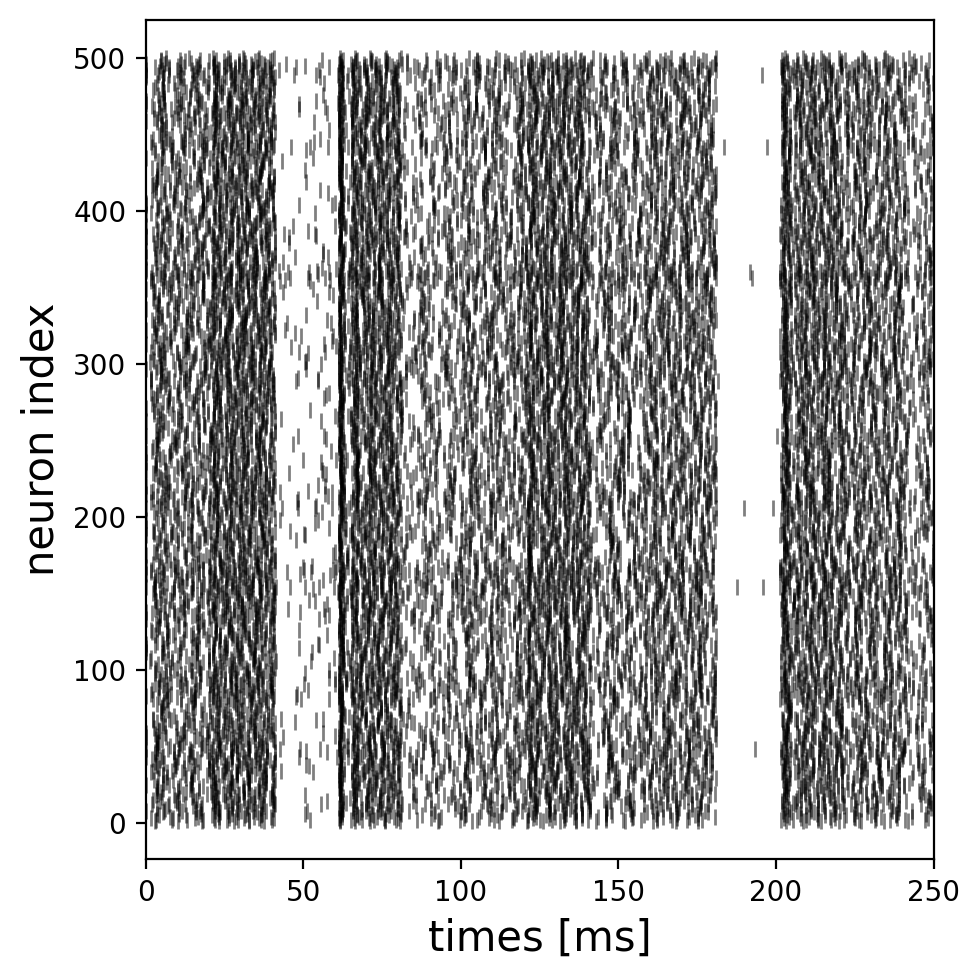

In [56]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.set_xlim(0,250)

ax.plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

ax.set_xlabel(r"times [ms]", size=15)
ax.set_ylabel(r"neuron index", size=15)

plt.tight_layout()
plt.show()

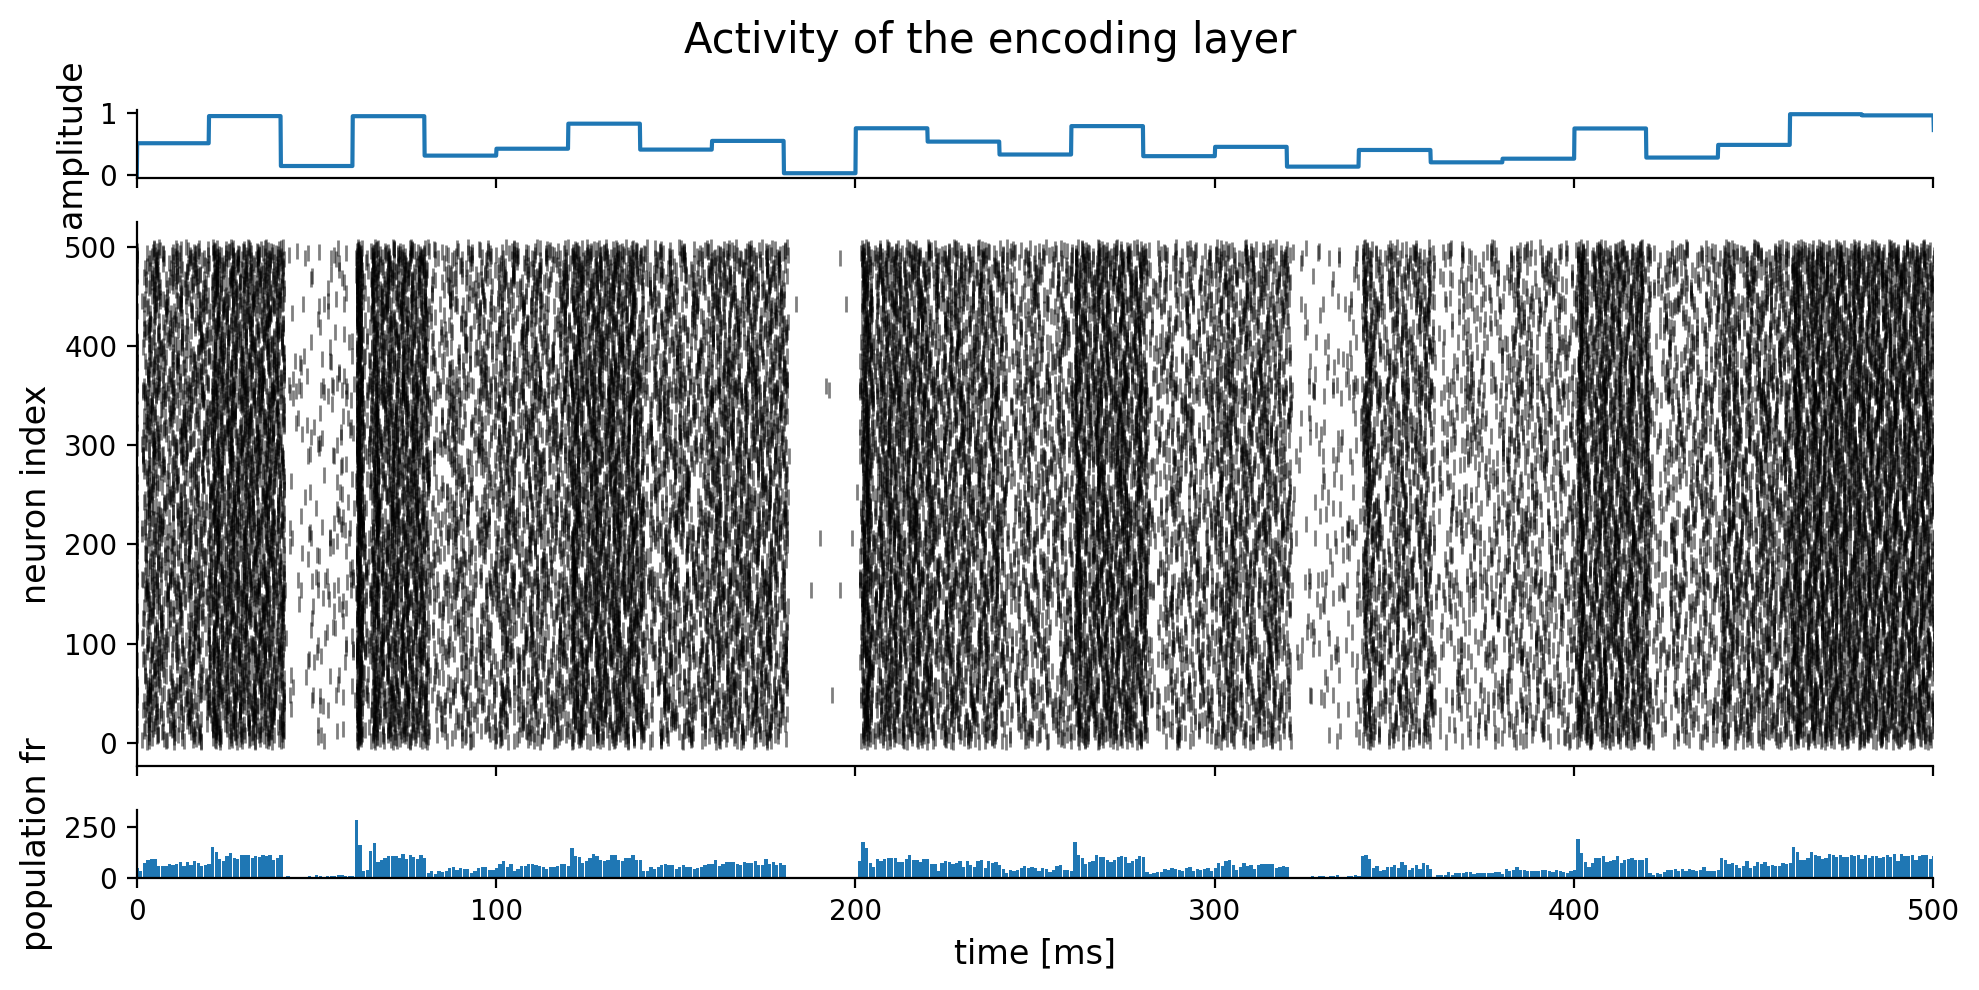

In [59]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks.events["times"],
    bins=np.linspace(
        enc_spks.events["times"].min(), 
        enc_spks.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'amplitude', size=12)
ax[0].spines[["top","right"]].set_visible(False)

ax[1].set_ylabel(r"neuron index", size=12)
ax[1].spines[["top","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr", size=12)
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'time [ms]', size=12)

fig.suptitle("Activity of the encoding layer", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer.pdf"), dpi=200)
plt.show()

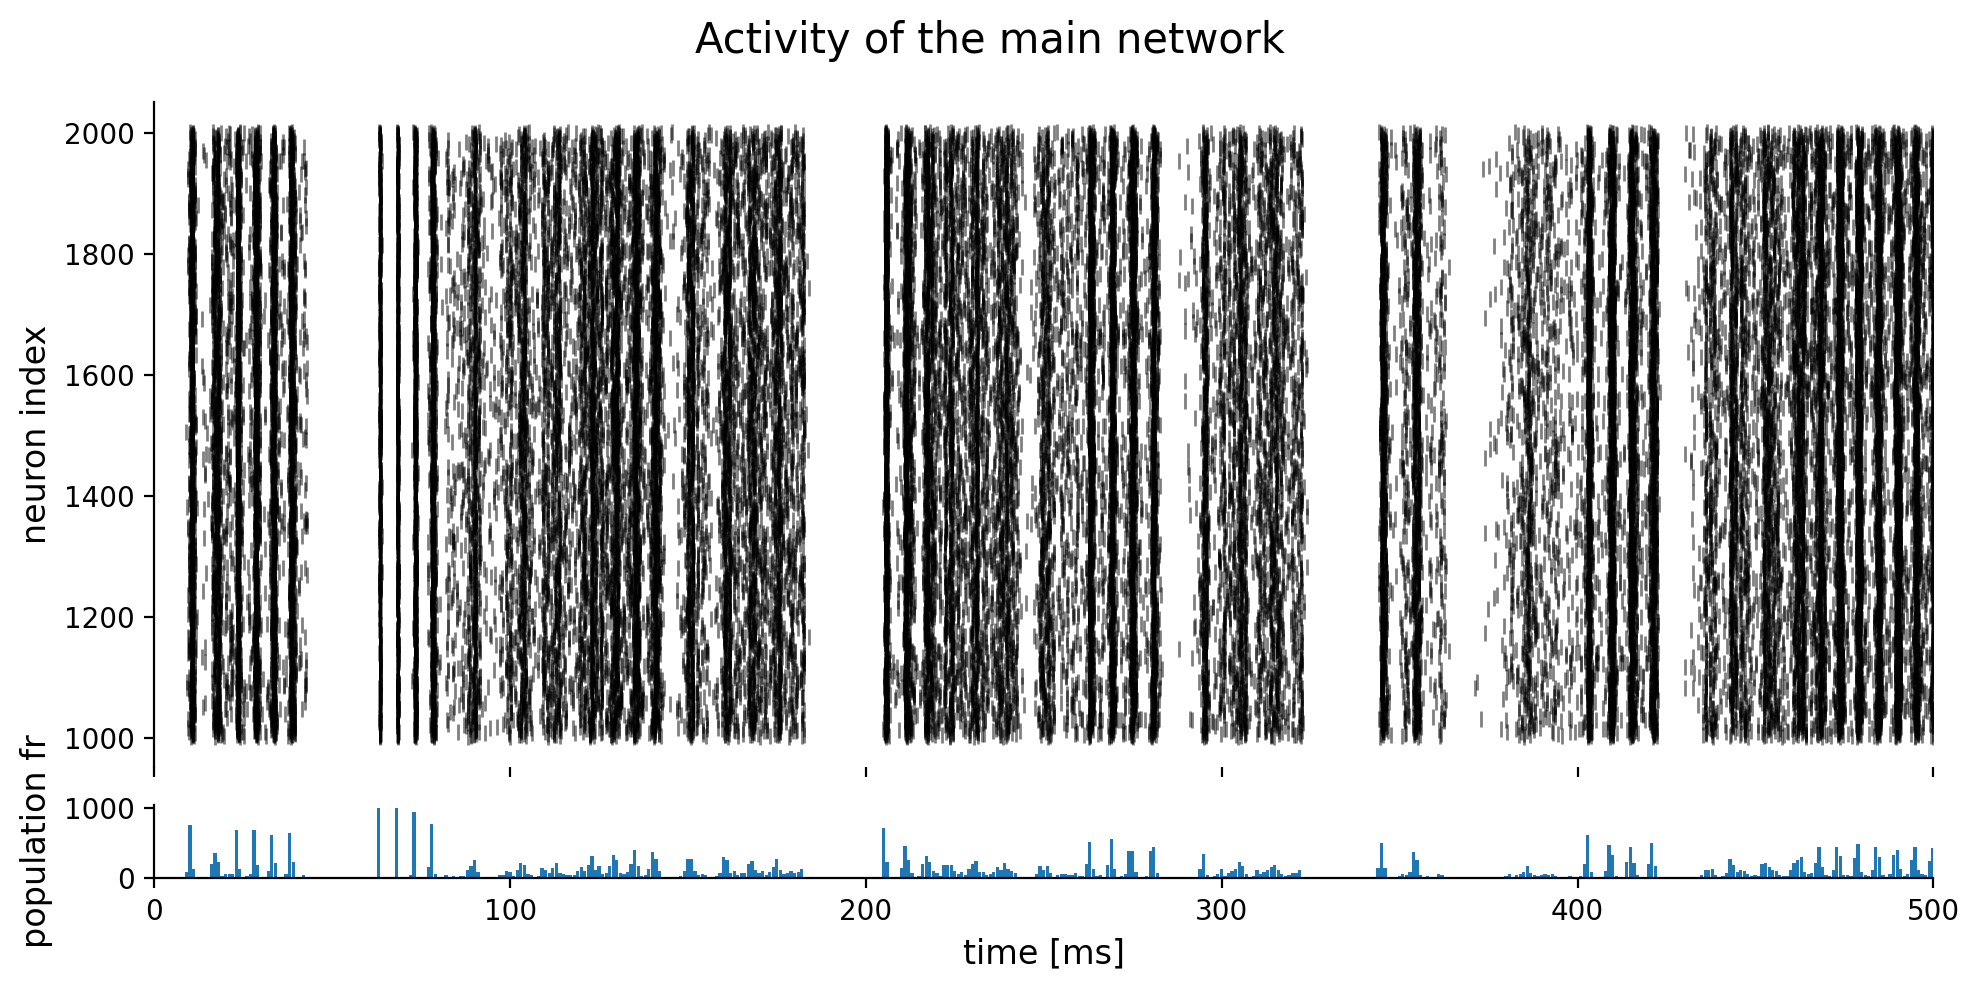

In [63]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    spikes_e.events["times"],
    spikes_e.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    spikes_e.events["times"],
    bins=np.linspace(
        spikes_e.events["times"].min(), 
        spikes_e.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r"neuron index", size=12)
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr", size=12)
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'time [ms]', size=12)

fig.suptitle("Activity of the main network", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

In [65]:
from sklearn.decomposition import PCA

: 

In [ ]:
fig = plt.figure(
    figsize=(15,5),
    dpi=200
)

ax0 = fig.add_subplot(131)
m = ax0.imshow(
    np.corrcoef(
        main_states,
        enc_states
    ),
    origin="lower"
)
ax0.set_xticks([0,500,1000,1500])
ax0.set_yticks([0,500,1000,1500])
ax0.set_xlabel("main - enc_layer")
ax0.set_ylabel("main - enc_layer")
ax0.set_title("Correlation between the activity \n of artificial neurons")
fig.colorbar(m, ax=ax0)

ax1 = fig.add_subplot(132)
main_X = PCA(n_components=np.shape(main_states)[0]).fit_transform(main_states.T)
ax1.plot(
    main_X[:,0],
    main_X[:,1],
    linewidth=0.5,
    color="black"
)
ax1.set_title("Analyse of the main layer activity")
ax1.set_xlabel("pc1")
ax1.set_ylabel("pc2")

ax2 = fig.add_subplot(133)
enc_X = PCA(n_components=np.shape(enc_states)[0]).fit_transform(enc_states.T)
ax2.plot(
    enc_X[:,0],
    enc_X[:,1],
    linewidth=0.5,
    color="black"
)
ax2.set_xlabel("pc1")
ax2.set_ylabel("pc2")
ax2.set_title("Analyse of the encoding layer activity")

fig.suptitle("Activity analysis", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "population_activity_analysis.pdf"), dpi=200)
plt.show()

### _decoding the activity_

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
enc_states.shape, inp_amplitudes.shape

((500, 200000), (1000,))

In [26]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [27]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

# save enc_states and signal
np.save(os.path.join(results_fodler_name, "main_estimate"), main_estimate)
np.save(os.path.join(results_fodler_name, "main_capacity"), main_capacity)
np.save(os.path.join(results_fodler_name, "enc_estimate"), enc_estimate)
np.save(os.path.join(results_fodler_name, "enc_capacity"), enc_capacity)

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer: 
	- Capacity=0.43738779586773097, MSE=0.04726859652328303
Main Circuit: 
	- Capacity=0.37790136839510324, MSE=0.053552851531496255


In [ ]:
times = np.load()

In [1]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    times,
    sig
)

ax.plot(
    times[:-1],
    enc_estimate,
    alpha=0.5,
    label="encoding layer"
)

ax.plot(
    times[:-1],
    main_estimate,
    alpha=0.5,
    label="main network"
)

ax.legend()

ax.set_xlim(0,500)
ax.set_xlabel("time [ms]")
ax.set_ylabel("amplitude [ua]")

plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

In [29]:
from utils.capacity import compute_capacity_sequential

subsampling_factor = 1 # ms
max_lag = 60 # ms
step_lag = 2 / subsampling_factor

In [30]:
time_capacity, encoder_capacity, main_capacity = compute_capacity_sequential(
    time_vector=times,
    signal=sig[1:], 
    enc_states=enc_states,
    ex_states=main_states,
    subsampling_factor=subsampling_factor,
    max_lag=max_lag,
    step_lag=step_lag,
    dt=dt
)

np.save(os.path.join(results_fodler_name, "time_capacity"), time_capacity)
np.save(os.path.join(results_fodler_name, "encoder_capacity"), encoder_capacity)
np.save(os.path.join(results_fodler_name, "mains_capacity"), main_capacity)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.43738779586773097, MSE=0.04726859652328303
Main Circuit: 
	- Capacity=0.37790136839510324, MSE=0.053552851531496255
Lag = 2.0 ms
Encoding Layer: 
	- Capacity=0.5610811325965609, MSE=0.03687086525899972
Main Circuit: 
	- Capacity=0.4847038228206617, MSE=0.04360108363013061
Lag = 4.0 ms
Encoding Layer: 
	- Capacity=0.6350812934416045, MSE=0.030650628390867716
Main Circuit: 
	- Capacity=0.5835464689186699, MSE=0.0349785801498447
Lag = 6.0 ms
Encoding Layer: 
	- Capacity=0.6796987401281688, MSE=0.026898644802861495
Main Circuit: 
	- Capacity=0.6381417779237807, MSE=0.0305191089774098
Lag = 8.0 ms
Encoding Layer: 
	- Capacity=0.7109905408521734, MSE=0.024267606722948726
Main Circuit: 
	- Capacity=0.6864968191857137, MSE=0.02672883645363236
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.7179970475373401, MSE=0.023675733181912476
Main Circuit: 
	- Capacity=0.7137948744311577, MSE=0.02454210902085787
Lag = 12.0 ms
Encoding Layer: 
	- Capacity=0.7063139

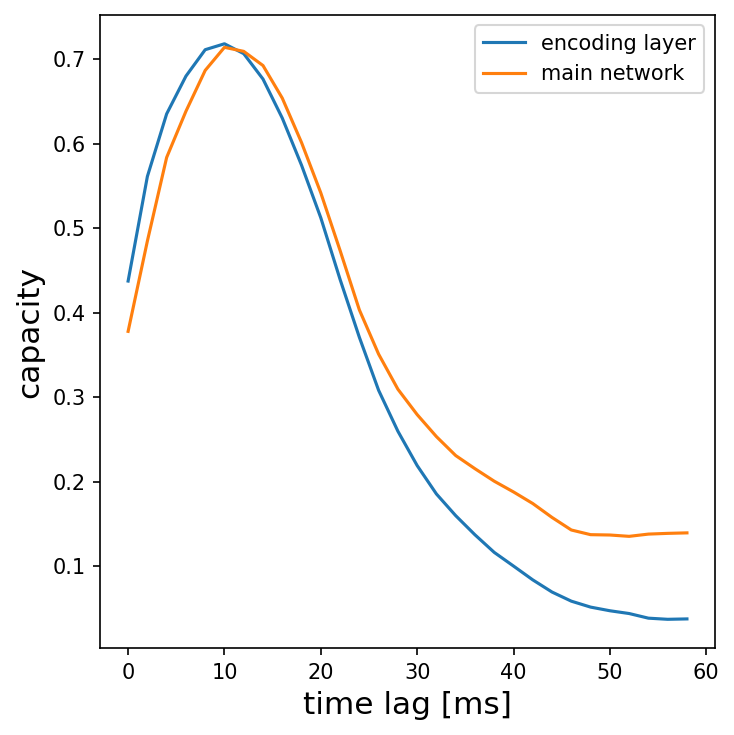

Total capacity (encoder): 19.21778443116595 ms
Total capacity (processor): 21.78000070127939 ms


: 

In [37]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=150
)

ax.plot(
    time_capacity,
    encoder_capacity,
    label="encoding layer"
)

ax.plot(
    time_capacity,
    main_capacity,
    label="main network"
)

ax.set_ylabel("capacity", size=15)
ax.set_xlabel("time lag [ms]", size=15)

ax.legend()

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "memory_capacity.pdf"))
plt.show()

print(f"Total capacity (encoder): {np.sum(encoder_capacity)*step_lag} ms")
print(f"Total capacity (processor): {np.sum(main_capacity)*step_lag} ms")